# What can a recurrent network learn?

In this exercise, we will construct a set of simple strings, and train a LSTM network, and see what sequence-concepts these networks can learn. 

In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import random

# A set of simple strings

## Remembering state

In these strings, we will generate random letters, but any letter following the S must be the same as the letter following the previous R

First, let's revise some Python to figure out how to generate these strings.

(Later on, you can vary this function to compute different types of strings, to see what a LSTM net can do. ) 

Now we put all these functions together into a function to generate a set of strings and their 0/1 labels

This will be used to generate training and test data. 

*** after using this version, you should change this function (or define another function) to generate strings of a different type, and then go through the worksheet again ****

In [4]:
def generate_RS_memory_strings(n_strings, string_length, charset):
    """
    n_strings : number of strings to generate
    n : length of the string to be generated
    charset : set of characters to use
    specialchar : the memorize symbol (a character)
    valid : boolean - memorisation correct if True, incorrect if false
    """
    char_list = list( charset )
    string_list = []
    label_list = []
    
    
    for s_counter in range(0,n_strings):
        label = random.randint(0,1)
        this_string_list = []
        
        Rpos1 = random.randint(0,string_length-2) # last possible position is second-last character
        Rpos2 = random.randint(0,string_length-2)
        while np.abs(Rpos1 - Rpos2) < 2:
            Rpos2 = random.randint(0,string_length-2)
        if Rpos1 > Rpos2:
            Rpos1, Rpos2 = (Rpos2, Rpos1) # in python you can swap variable values like this
        for i in range(0,string_length):
            this_string_list.append( random.choice( char_list ) )
        this_string_list[Rpos1] = 'R'
        this_string_list[Rpos2] = 'S'
        if label: 
            this_string_list[Rpos2+1] = this_string_list[Rpos1+1] # memory and correct recall !
        else:
            while this_string_list[Rpos2+1] == this_string_list[Rpos1+1]:
                this_string_list[Rpos2+1] = random.choice( char_list )
        string_list.append( ''.join( this_string_list ) )
        label_list.append( label )
    
    return string_list, label_list
        

In [5]:
# Test the function ! 
# make sure the class labels are what is wanted. (Make sure you understanda what the class labels mean here.)

ss, ss_labels = generate_RS_memory_strings(10, 8, 'abc')
ss, ss_labels

(['bRacSbbc',
  'RbbbSaab',
  'bRbcaSbc',
  'bRbSacaa',
  'RccScbcb',
  'aRbSbcab',
  'bRacacSa',
  'accRacSb',
  'bRaaaSbc',
  'aRbbbSbb'],
 [0, 0, 1, 0, 1, 1, 1, 0, 0, 1])

Constructing a dict that maps characters in a string to numbers, counting up from 1:

In [6]:
# This constructs and returns two dicts, that can be used to map the characters that are in the string
# to ints, and those ints back to the characters

def char_to_integers( mystring ):
    charlist = list( set( list( mystring )))
    nums = range(1,len(charlist)+1)
    c2ndict = dict()
    n2cdict = dict()
    for c,n in zip(charlist,nums):
        c2ndict[c]=n
        n2cdict[n]=c
    return c2ndict, n2cdict

In [7]:
# test it
char_to_integers('elephant')

({'n': 1, 'a': 2, 'l': 3, 't': 4, 'h': 5, 'p': 6, 'e': 7},
 {1: 'n', 2: 'a', 3: 'l', 4: 't', 5: 'h', 6: 'p', 7: 'e'})

In [8]:
def string_to_int_vec( s, pad_length, code_dict):
    """
    Converts a string to a vector of ints, using a character-encoding dictionary
    
    s : the string to convert
    padlength : the length to pad the string to, with initial zeros
    code : dict giving the conversion from chars to integers
    """
    slen = len(s)
    assert slen <= pad_length
    v = np.zeros([pad_length])
    startx = pad_length - slen
    stringlist = list(s)
    for i in range(0,slen):
        v[startx + i] = code_dict[stringlist[i]]
    return v
    

In [9]:
def strings_to_nparray(strings, pad_length, char_to_integers):
    """
    Converts a lest of strings to an numpy array, which can be used as training
    or testing data
    
    strings : a list of strings
    maxlen  : an integer, greater than or equal to the max length of any of the strings
    
    This function converts a list of n strings into a n x maxlen numpy array, containing
    the coded strings
    """
    mat = np.zeros([len(strings),pad_length])
    for i in range(0,len(strings)):
        mat[i,:] = string_to_int_vec( strings[i], pad_length, char_to_integers )
    return mat


In [10]:
c2i,i2c = char_to_integers(''.join(ss))
c2i

{'a': 1, 'R': 2, 'S': 3, 'c': 4, 'b': 5}

In [11]:
# test strings_to_nparray

data = strings_to_nparray(ss,8,c2i)
data

array([[5., 2., 1., 4., 3., 5., 5., 4.],
       [2., 5., 5., 5., 3., 1., 1., 5.],
       [5., 2., 5., 4., 1., 3., 5., 4.],
       [5., 2., 5., 3., 1., 4., 1., 1.],
       [2., 4., 4., 3., 4., 5., 4., 5.],
       [1., 2., 5., 3., 5., 4., 1., 5.],
       [5., 2., 1., 4., 1., 4., 3., 1.],
       [1., 4., 4., 2., 1., 4., 3., 5.],
       [5., 2., 1., 1., 1., 3., 5., 4.],
       [1., 2., 5., 5., 5., 3., 5., 5.]])

In [12]:
# a useful checking function is to do the back-conversion

def int_vec_to_string(v,i2c):
    """
    v : an array of ints, possibly with initial zeros to be ignored
    i2c : a dict mapping ints to chars
    """
    charlist = []
    i = 0 
    for i in range(0,v.shape[0]):
        if v[i] > 0:
            charlist.append( i2c[v[i]] )
    return ''.join(charlist)

In [13]:
# now we can check the conversions
# the original string and its back-conversion from its vector-coding should be the same
ss[2], int_vec_to_string(data[2,:],i2c), ss_labels[2]

('bRbcaSbc', 'bRbcaSbc', 1)

# Tokenizing and preparing datasets

In [14]:
pad_length = 10

In [15]:
training_strings, training_label_list = generate_RS_memory_strings(5000, pad_length, set('ab'))

In [16]:
test_strings, test_label_list = generate_RS_memory_strings(5000, pad_length, set('ab'))

In [17]:
training_strings[:5], training_label_list[:5]

(['aabRbbaSba', 'RaaabaaSaa', 'aRbabSbaab', 'RbbababbSb', 'bRbbabSbab'],
 [1, 1, 1, 1, 1])

In [18]:
test_strings[:5], test_label_list[:5]

(['bRbbaabSbb', 'RbaabSaaba', 'bRabSababa', 'bbaaaRaSba', 'baabbRaSbb'],
 [1, 0, 1, 0, 0])

In [19]:
train_string_set = set( training_strings )
test_string_set = set( test_strings )

# there is only a finite number of strings of length 10 - how big is the overlap between the strings in 
# the training set and the test set (or, does the training set already contain all the strings? )

# we can use set intersection to find out. 
overlap = train_string_set.intersection( test_string_set)
len(train_string_set), len( overlap ), len(test_string_set)

(3599, 1849, 3628)

In [20]:
y_train = np.asarray(training_label_list)
y_test = np.asarray(test_label_list)

In [21]:
y_train.shape, y_test.shape

((5000,), (5000,))

In [22]:
# this inefficiently ensures that we have complete character codinng and decoding
# dictionaries by scanning through the entire training set
c2i, i2c = char_to_integers(''.join(training_strings))
n_chars = len( c2i ) + 1 # we leave 0 as the padding symbol

In [23]:
x_train = strings_to_nparray(training_strings, pad_length, c2i)
x_test = strings_to_nparray(test_strings, pad_length, c2i)
(x_train.shape, x_test.shape)

((5000, 10), (5000, 10))

# Learning and Testing

In [24]:
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Concatenate
from tensorflow.keras.layers import Embedding, Attention
from tensorflow.keras.layers import LSTM, SimpleRNN



In [25]:
n_chars  # the number of different characters used in the training set strings

5

In [26]:
embedding_matrix = np.eye(n_chars+1)
embedding_matrix

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]])

## Visualising the outputs of the LSTM layer during the sequence

Let us check to see if the LSTM works for sequences of different lengths, even though we only trained it on sequences of length 10. And let use visualise the output of the LSTM layer at all stages of sequence processing. 

To do this visualisation, we will transfer the weights from the model we trained to a different model, which we use only for visualisation

In [27]:
def plot_lstm_outputs(lstm_ouputs, viz_string):
    plt.imshow(lstm_ouputs)
    plt.xticks(range(0, len(viz_string)), [c for c in viz_string])
    plt.yticks(range(0, 10),[i for i in range(0,10)])
    plt.colorbar()

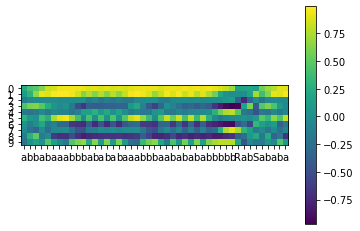

In [116]:
plot_lstm_outputs(lstm_outputs[0,:,:].transpose(), viz_string)

#### Investigation:  Now compare the heatmaps generated when you change one character of viz_string. Try changing characters that don't matter, and also characters that do, and see what changes happen in the outputs of the LSTM layer. 

*** Self-help: can you look up in the matplotlib documentation (or google) to put the letters of the viz_string along the x-axis of the heatmap? This would make it easier to see what outputs are changing when ***

Exercise: use the model_for_viz outputs as a matrix and multiply the matrix with these weights, to get the input to the last layer of the model at each character of the sequence. 

In [27]:
# Variable-length int sequences.
query_input = Input(shape=(None,), dtype='int32')

# Embedding lookup.
token_embedding = Embedding(n_chars+1, output_dim=n_chars+1, name='embedding')
# Query embeddings of shape [batch_size, Tq, dimension].
query_embeddings = token_embedding(query_input)

# LSTM layer.
lstm_layer = LSTM(10, activation='tanh',return_sequences=True)
# Query encoding of shape [batch_size, Tq, filters].
query_seq_encoding = lstm_layer(query_embeddings)

# Query-value attention of shape [batch_size, Tq, filters].
query_value_attention_seq = Attention()([query_seq_encoding, query_seq_encoding])

# Reduce over the sequence axis to produce encodings of shape
# [batch_size, filters].
#query_encoding = GlobalAveragePooling1D()(
#    query_seq_encoding)
#query_value_attention = tf.keras.layers.GlobalAveragePooling1D()(
#    query_value_attention_seq)

# Concatenate query and document encodings to produce a DNN input layer.
input_layer = Concatenate()([query_seq_encoding, query_value_attention_seq])


In [28]:
# We will create another model, exactly similar to the LSTM model above, but which has been
# altered to give the LSTM outputs for the whole sequence

# We will not train this model at all - we are simply copying the weights of the trained model into a different
# model that gives the complete output of the LSTM layer for the whole sequence, instead of a single yes/no prediction

# Concatenate query and document encodings to produce a DNN input layer.
decoder_lstm_layer = LSTM(10, activation='tanh')(query_value_attention_seq)
dense_layer = Dense(1, activation='sigmoid')(decoder_lstm_layer)

In [29]:
model = Model(query_input, dense_layer)
print(model.layers[1])

In [30]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 6)      36          input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, None, 10)     680         embedding[0][0]                  
__________________________________________________________________________________________________
attention (Attention)           (None, None, 10)     0           lstm[0][0]                       
                                                                 lstm[0][0]                   

In [31]:
embedding_matrix = np.eye(n_chars+1)
model.layers[1].set_weights([embedding_matrix])
model.layers[1].trainable = False

In [32]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [33]:
model.layers

In [34]:
history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test,y_test))

Train on 5000 samples, validate on 5000 samples
Epoch 1/50
5000/5000 [==============================] - 5s 988us/sample - loss: 0.6934 - accuracy: 0.5150 - val_loss: 0.6933 - val_accuracy: 0.5114
Epoch 2/50
5000/5000 [==============================] - 1s 244us/sample - loss: 0.6926 - accuracy: 0.5150 - val_loss: 0.6931 - val_accuracy: 0.5036
Epoch 3/50
5000/5000 [==============================] - 1s 245us/sample - loss: 0.6919 - accuracy: 0.5264 - val_loss: 0.6909 - val_accuracy: 0.5296
Epoch 4/50
5000/5000 [==============================] - 1s 238us/sample - loss: 0.6895 - accuracy: 0.5420 - val_loss: 0.6884 - val_accuracy: 0.5282
Epoch 5/50
5000/5000 [==============================] - 1s 245us/sample - loss: 0.6861 - accuracy: 0.5460 - val_loss: 0.6861 - val_accuracy: 0.5482
Epoch 6/50
5000/5000 [==============================] - 1s 271us/sample - loss: 0.6843 - accuracy: 0.5472 - val_loss: 0.6841 - val_accuracy: 0.5450
Epoch 7/50
5000/5000 [==============================] - 1s 250us

In [ ]:
# Attention Layer from Bahdanau et. al 
# https://arxiv.org/abs/1409.0473
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)
        
    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()
    

In [42]:
pred = model.predict(x_test[:10,:])
print([int(p[0]>0.5) for p in pred])
y_test[:10]

[1, 0, 1, 0, 0, 0, 1, 0, 1, 1]


array([1, 0, 1, 0, 0, 0, 1, 0, 1, 1])

In [55]:
# Now let us define a string for which we will visualise the outputs of the LSTM layer. 
# Let's use a string of length 19, say.  How long can you make this string so that the original 
# model still works?  

viz_string = 'abRabababaSbbb'
viz_vector = string_to_int_vec(viz_string, len(viz_string), c2i)
viz_vector = viz_vector.reshape([1,viz_vector.shape[0]]) # this makes it a data set of size 1
print(viz_vector)
print(viz_vector.shape)

[[2. 4. 1. 2. 4. 2. 4. 2. 4. 2. 3. 4. 4. 4.]]
(1, 14)


In [56]:
model.predict(viz_vector)

array([[0.99961686]], dtype=float32)